In [2]:
from Species import Ca40
from structures import Chain, Laser
from Chamber import Chamber
from utilities import lambdicke, time_evolve
from construct_H_tree import construct_H_tree

import trical.misc.constants as cst

import numpy as np
from math import sqrt

ion1 = Ca40([("S1/2", -1/2, "S"), ("D5/2", -1/2, "D")])
ion2 = Ca40([("S1/2", -1/2, "S"), ("D5/2", -1/2, "D")])

chain = Chain([ion1, ion2], trap_freqs=[3e6, 3e6, 1e6], selected_modes=[])
mode = chain.modes[-1] # COM in Z
mode.modecutoff(6)

chain.selected_modes = [mode]

laser1 = Laser(phi=0, k_hat=np.array([1,0,1])/sqrt(2), eps_hat = 
               np.array([1, 0, -1])/sqrt(2))

laser2 = Laser(phi=0, k_hat=np.array([1,0,1])/sqrt(2), eps_hat = 
               np.array([1, 0, -1])/sqrt(2))

chamber = Chamber(chain = chain, lasers = [laser1, laser2], 
                  B = 4e-4, Bhat = np.array([0,0,1]))

chamber.set_laser_wavelength_from_transition(0, ion1.transition(("S", "D")))
chamber.set_laser_wavelength_from_transition(1, ion2.transition(("S", "D")))

eta = lambdicke(mode, ion1, laser1)

rabi = sqrt(1e3 * 40e3) / eta # in Hz (linear Rabi)
chamber.set_laser_intensity_from_rabi_frequency(0, rabi, ion1.transition(("S", "D")))
chamber.set_laser_intensity_from_rabi_frequency(1, rabi, ion2.transition(("S", "D")))

delta = mode.eigenfreq + (40e3 - 80)
laser1.detune(delta)
laser2.detune(-delta)

timescale = 1e-6

H = construct_H_tree(chamber, timescale)
H.apply_ld_and_rwa_approximations(n_cutoff = mode.N, ld_cond_th = 1e-2, rwa_cutoff=5e5)


Expanding to 2nd order in the Lamb-Dicke approximation
Expanding to 2nd order in the Lamb-Dicke approximation
Expanding to 2nd order in the Lamb-Dicke approximation
Expanding to 2nd order in the Lamb-Dicke approximation


10.0%. Run time:   0.52s. Est. time left: 00:00:00:04
20.0%. Run time:   1.03s. Est. time left: 00:00:00:04
30.0%. Run time:   1.53s. Est. time left: 00:00:00:03
40.0%. Run time:   2.03s. Est. time left: 00:00:00:03
50.1%. Run time:   2.53s. Est. time left: 00:00:00:02
60.1%. Run time:   3.03s. Est. time left: 00:00:00:02
70.1%. Run time:   3.54s. Est. time left: 00:00:00:01
80.1%. Run time:   4.05s. Est. time left: 00:00:00:01
90.1%. Run time:   4.56s. Est. time left: 00:00:00:00
100.0%. Run time:   5.06s. Est. time left: 00:00:00:00
Total run time:   5.06s


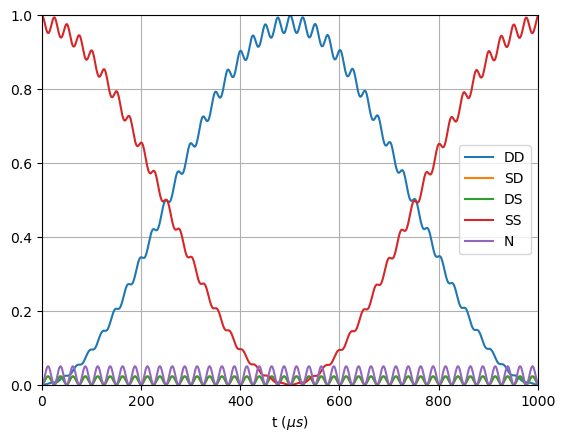

In [3]:
from qutip import tensor

psi_ion = tensor(ion1.state['S'], ion2.state['S'])
psi_mot = mode.setstate(0)

# Initial tensor-ed state
psi_0 = tensor(psi_ion, psi_mot)
proj_gg = chain.ion_projector([1, 2], ['S', 'S'])
proj_ge = chain.ion_projector([1, 2], ['S', 'D'])
proj_eg = chain.ion_projector([1, 2], ['D', 'S'])
proj_ee = chain.ion_projector([1, 2], ['D', 'D'])

N = chain.number_operator(0, "N")

duration = 1_000
times = np.linspace(0, duration, 1000)
results = time_evolve(H, psi_0, times, expt_ops=[proj_ee, proj_ge, proj_eg, proj_gg, N], progress_bar= True)
results.quick_plot()